# SEMA-1D 

SEMA-1D is a fine-tuned ESM-1v model aimed to predict epitope resiudes based on antigen protein sequence

The MIT License (MIT)
Copyright (c) 2016 AYLIEN
Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

## Requirements

In [1]:
import os
# set cuda params
# 'TORCH_HOME'directory will be used to save origenal esm-1v weights
os.environ['TORCH_HOME'] = "../torch_hub"
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [2]:
import scipy
import sklearn
import esm

import pandas as pd
import numpy as np

import torch
from torch.utils.data import Dataset
from torch import nn
import math

import transformers
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers import Trainer, TrainingArguments, EvalPrediction

from esm.pretrained import load_model_and_alphabet_hub

from sklearn.metrics import r2_score, mean_squared_error

/mnt/20tb/shevtsov/miniconda3/envs/sema_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Model and metrics

In [3]:
class PDB_Dataset(Dataset):
    """
    A class to represent a sutable data set for model. 
    
    convert original pandas data frame to model set,
    where 'token ids' is ESM-1v embedings corresponed to protein sequence (max length 1022 AA)
    and 'lables' is a contact number values
    Attributes:
        df (pandas.DataFrame): dataframe with two columns: 
                0 -- preotein sequence in string ('GLVM') or list (['G', 'L', 'V', 'M']) format
                1 -- contcat number values in list [0, 0.123, 0.23, -100, 1.34] format
        esm1v_batch_converter (function):
                    ESM function callable to convert an unprocessed (labels + strings) batch to a
                    processed (labels + tensor) batch.
        label_type (str):
                type of model: regression or binary

    """
    def __init__(self, df, label_type ='regression'):
        """
        Construct all the necessary attributes to the PDB_Database object.
        
        Parameters:
            df (pandas.DataFrame): dataframe with two columns: 
                0 -- protein sequence in string ('GLVM') or list (['G', 'L', 'V', 'M']) format
                1 -- contcat number values in list [0, 0.123, 0.23, -100, 1.34] format
            label_type (str):
                type of model: regression or binary
        """
        self.df = df
        _, esm1v_alphabet = esm.pretrained.esm2_t33_650M_UR50D()
        self.esm1v_batch_converter = esm1v_alphabet.get_batch_converter()
        self.label_type = label_type

    def __getitem__(self, idx):
        item = {}
        _, _, esm1b_batch_tokens = self.esm1v_batch_converter([('' , ''.join(self.df.iloc[idx,0])[:1022])])
        item['token_ids'] = esm1b_batch_tokens
        # item['labels'] = torch.unsqueeze(torch.LongTensor(self.df.iloc[idx, 1][:1022]),0)
        
        if self.label_type == 'regression':
            item['labels'] = torch.unsqueeze(torch.tensor(self.df.iloc[idx, 1][:1022]),0)
        # else:
        #     labels = self.df.iloc[idx, 1][:1022]
        #     binary_labels = []
        #     for l in labels:
        #         if l > 0:
        #             binary_labels.append(1) 
        #         elif l == 0:
        #             binary_labels.append(1) 

            

        return item

    def __len__(self):
        return len(self.df)

In [4]:
class ESM1vForTokenClassification(nn.Module):

    def __init__(self, num_labels = 2, pretrained_no = 1):
        super().__init__()
        self.num_labels = num_labels
        self.model_name = "esm2_t33_650M_UR50D" #+ str(pretrained_no) 
        
        self.esm1v, self.esm1v_alphabet = load_model_and_alphabet_hub(self.model_name)        
        
        self.classifier = nn.Linear(1280, self.num_labels)

    def forward(self, token_ids, labels):

        outputs = self.esm1v.forward(token_ids, repr_layers=[33])['representations'][33]
        outputs = outputs[:,1:-1,:]
        logits = self.classifier(outputs)
        # print('logits', logits)
        return SequenceClassifierOutput(logits=logits)

In [5]:
# model_path = '/home/shevtsov/SEMAi/models/sema_1d_esm2_continous_noncut_log10_0.pth'
# model = ESM2ForTokenClassification()
# model.load_state_dict(torch.load(
#     model_path,
#     map_location=torch.device('cpu'),
# ))

In [6]:
def compute_metrics_regr(p: EvalPrediction):
    
    preds = p.predictions[:,:,1]

    batch_size, seq_len = preds.shape    
    out_labels, out_preds = [], []

    for i in range(batch_size):
        for j in range(seq_len):
            if p.label_ids[i, j] > -1:
                out_labels.append(p.label_ids[i][j])
                out_preds.append(preds[i][j])
                
    # out_labels_regr = [math.log(t+1) for t in out_labels]
    out_labels_regr = out_labels

    
    return {
        "pearson_r": scipy.stats.pearsonr(out_labels_regr, out_preds)[0],
        "mse": mean_squared_error(out_labels_regr, out_preds),
        "r2_score": r2_score(out_labels_regr, out_preds)
    }


In [7]:
## you can train one model or ensemple of 5 models
def model_init_1():
    return ESM1vForTokenClassification(pretrained_no = 1).cuda()
def model_init_2():
    return ESM1vForTokenClassification(pretrained_no = 2).cuda()
def model_init_3():
    return ESM1vForTokenClassification(pretrained_no = 3).cuda()
def model_init_4():
    return ESM1vForTokenClassification(pretrained_no = 4).cuda()
def model_init_5():
    return ESM1vForTokenClassification(pretrained_no = 5).cuda()

In [8]:
class MaskedMSELoss(torch.nn.Module):
    def __init__(self):
        super(MaskedMSELoss, self).__init__()

    def forward(self, inputs, target, mask):   
        diff2 = (torch.flatten(inputs[:,:,1]) - torch.flatten(target)) ** 2.0 * torch.flatten(mask)
        result = torch.sum(diff2) / torch.sum(mask)
        if torch.sum(mask)==0:
            return torch.sum(diff2)
        else:
            #print('loss:', result)
            return result

In [9]:
class MaskedRegressTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
    
        # labels = inputs.pop("labels")
        labels = inputs["labels"]
        # labels = labels.squeeze().detach().cpu().numpy().tolist()
        # labels = [math.log(t+1) if t!=-100 else -100 for t in labels]
        # labels = torch.unsqueeze(torch.FloatTensor(labels), 0).cuda()
        masks = ~torch.eq(labels, -100).cuda()
        
        #masks = inputs.pop("masks")
        outputs = model(**inputs)
        logits = outputs.logits

        loss_fn = MaskedMSELoss()
        
        loss = loss_fn(logits, labels, masks)
        
        return (loss, outputs) if return_outputs else loss

In [10]:
def collator_fn(x):
    if len(x)==1:
        return x[0]
    print('x:', x)
    return x

## Data

In [11]:
import json
import pandas as pd
path = '/mnt/nfs_protein/ivanisenko/SEMA/dataset/SEMA_DS.json'
def load_datasets(path, filtr_length = False, label_type = 'regression'):
    with open(path, 'r') as file:
        dataset = json.load(file)
        dataset = pd.DataFrame(dataset)

        if filtr_length:
            dataset = dataset[dataset['seq'].str.len() >= filtr_length]

        train_set = dataset[dataset['ds_type'] == 'train']
        test_set = dataset[dataset['ds_type'] == 'test_new']
        # test_set = dataset[dataset['ds_type'] == 'test_original']

        train_ds = PDB_Dataset(train_set[['seq', 'contact_number']], 
                      label_type =label_type)
        test_ds = PDB_Dataset(test_set[['seq', 'contact_number']], 
                      label_type =label_type)

    return train_ds , test_ds

In [ ]:
train_ds , test_ds = load_datasets(path, filtr_length = 0)

In [31]:
# train_set = pd.read_csv('../data/train_set.csv')
# train_set = train_set.groupby('pdb_id_chain').agg({'resi_pos': list,
#                                  'resi_aa': list,
#                                  'contact_number': list}).reset_index()

# # train_set = train_set.iloc[:10, :]
# # the first run will take about 5-10 minutes, because esm weights should be downloaded
# train_ds = PDB_Dataset(train_set[['resi_aa', 'contact_number']], 
#                       label_type ='regression')

In [32]:
# test_set = pd.read_csv('../data/test_set.csv')
# test_set = test_set.groupby('pdb_id_chain').agg({'resi_pos': list,
#                                  'resi_aa': list,
#                                  'contact_number': list}).reset_index()

# # test_set = test_set.iloc[:10, :]

# test_ds = PDB_Dataset(test_set[['resi_aa', 'contact_number']],
#                       label_type ='regression')

## Model training and test

In [19]:
training_args = TrainingArguments(
    output_dir='./results_fold' ,          # output directory
    num_train_epochs=2,              # total number of training epochs
    per_device_train_batch_size=1,   # batch size per device during training
    per_device_eval_batch_size=1,   # batch size for evaluation
    warmup_steps=0,                # number of warmup steps for learning rate scheduler
    learning_rate=1e-05,             # learning rate
    weight_decay=0.0,                # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=200,               # How often to print logs
    save_strategy = "no",
    do_train=True,                   # Perform training
    do_eval=True,                    # Perform evaluation
    evaluation_strategy="epoch",     # evalute after each epoch
    gradient_accumulation_steps=1,  # total number of steps before back propagation
    fp16=False,                       # Use mixed precision
    run_name="PDB_binary",      # experiment name
    seed=42,                         # Seed for experiment reproducibility
    load_best_model_at_end=False,
    metric_for_best_model="eval_accuracy",
    greater_is_better=True,

)

In [34]:
#create direactory to weights storage
if not os.path.exists("../models/"):
    os.makedirs("../models/")

### one model

In [35]:
trainer = MaskedRegressTrainer(
    model=model_init_1(),                   # the instantiated 🤗 Transformers model to be trained
    args=training_args,                     # training arguments, defined above
    train_dataset=train_ds,                 # training dataset
    eval_dataset=test_ds,                   # evaluation dataset
    data_collator = collator_fn,
    compute_metrics = compute_metrics_regr,    # evaluation metrics
)

trainer.train()

#save weights
torch.save(trainer.model.state_dict(), "../models/sema_1d_esm2_continous_noncut_log10_0.pth")

Detected kernel version 4.15.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Pearson R,Mse,R2 Score
1,0.152300,0.154504,0.282521,0.166098,0.057529
2,0.106000,0.155484,0.293520,0.169032,0.040884


In [40]:
s = 'CVNLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVCVNLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVCVNLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVCVNLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVCVNLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVCVNLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVCVNLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVCVNLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVCVNLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVCVNLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVCVNLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVCVNLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVCVNLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVCVNLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVCVNLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVCVNLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVCVNLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVCVNLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVCVNLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVCVNLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVV'
len(s)

1960

### ensemble of 5 models

In [ ]:
# for idx, model_init in enumerate([model_init_1, model_init_2, model_init_3, model_init_4, model_init_5]):

#     trainer = MaskedRegressTrainer(
#         model=model_init(),                   # the instantiated 🤗 Transformers model to be trained
#         args=training_args,                   # training arguments, defined above
#         train_dataset=train_ds,               # training dataset
#         eval_dataset=test_ds,                 # evaluation dataset
#         data_collator = collator_fn,
#         compute_metrics = compute_metrics_regr    # evaluation metrics
#     )

#     trainer.train()
    
#     #save weights
#     torch.save(trainer.model.state_dict(), f"../models/sema_1d_{str(idx)}.pth")

# Multimers test

In [31]:
from biopandas.pdb import PandasPdb
import pandas as pd
from pathlib import Path
from tqdm import tqdm

aa_3_to_1 = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
     'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
     'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
     'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}

In [32]:
def prepare_multimer_test_1D_model(path_to_pdbs, gap_length = 0):
    
    path_pdbs = Path(path_to_pdbs).glob("*.pdb")
    one_chain_prots = []
    test_df = pd.DataFrame(columns = ['seq', 'concat_number'])

    for pdb_path in tqdm(list(path_pdbs)):
        # read pdb
        atom_df =  PandasPdb().read_pdb(str(pdb_path)).df['ATOM']
        # create one letter aa columns
        atom_df['residue_letter'] =  atom_df['residue_name'].map(aa_3_to_1)
        # change mask values from -1 to -100
        atom_df.loc[atom_df['b_factor'] == -1, 'b_factor'] = -100
        atom_df.loc[atom_df['b_factor'] >= 0, 'b_factor'] = atom_df.loc[atom_df['b_factor'] >= 0, 'b_factor'].apply(lambda x: np.log10(x + 1))

        chains_dfs = [atom_df[atom_df['chain_id'] == chain] for chain in atom_df.chain_id.unique()]

        # filtr out sample if there is only on chain
        if len(chains_dfs) == 1:
            one_chain_prots.append(pdb_path)
            print(atom_df.chain_id.unique(), pdb_path)
            continue
        
        chains_contacts = []
        chains_seqs = []

        for ind, chain_df in enumerate(chains_dfs):

            # chain_df = chain_df.drop_duplicates(['residue_number'])
            chain_df = chain_df[chain_df.atom_name == 'CA']
            chains_seqs.append(''.join(chain_df['residue_letter']))

            if ind != 0:
                chains_contacts += [-100]*gap_length
            chains_contacts += chain_df['b_factor'].tolist()

        multimer_seq = ('G'*gap_length).join(chains_seqs)
        # print(pdb_path, len(multimer_seq))
            
        test_df.loc[test_df.shape[0] +1, :] = {'seq': multimer_seq, 'concat_number': chains_contacts}
    
    print('PDBs with only one chain:', len(one_chain_prots))

    return test_df

In [33]:
test_df = prepare_multimer_test_1D_model(
    '/mnt/nfs_protein/ivanisenko/SEMA/dataset/multimers/', gap_length = 0)
# multi_test_ds = PDB_Dataset(test_df)
# # with 0*gap
# trainer.evaluate(multi_test_ds)

 60%|██████    | 467/773 [00:33<00:14, 21.51it/s]

['B'] /mnt/nfs_protein/ivanisenko/SEMA/dataset/multimers/7K7I_B.pdb
['C'] /mnt/nfs_protein/ivanisenko/SEMA/dataset/multimers/7K7I_C.pdb


100%|██████████| 773/773 [01:06<00:00, 11.60it/s]

PDBs with only one chain: 2


# roc auc threshold

In [12]:
import json
import pandas as pd
path = '/home/shevtsov/SEMAi/data/SEMA_DS_4.5.json'
with open(path, 'r') as f:
    data = json.load(f)
    df_data = pd.DataFrame(data)

In [13]:
import json
import pandas as pd
path = '/home/shevtsov/SEMAi/data/SEMA_DS_4.5.json'

train_ds , test_ds = load_datasets(path, filtr_length = 0)

In [18]:
from sklearn.metrics import roc_curve,roc_auc_score
from tqdm import tqdm

path = '/home/shevtsov/SEMAi/models/sema_1d_esm2_continous_noncut_log10_0.pth'
model=model_init_1()
model.load_state_dict(torch.load(path))
model.eval()
model.cuda()

with torch.no_grad():
    preds=[]
    labels = []
    for it in tqdm(test_ds):
        # preds.append(model.forward(it['token_ids'].cuda(), labels = None)[0][0][:,1].cpu().numpy())
        # labels.append(it['labels'].squeeze(0).numpy())
        it_preds = model.forward(it['token_ids'].cuda(), labels = None)[0][0][:,1].cpu().numpy()
        it_labels = it['labels'].squeeze(0).numpy()
        for ind, label in enumerate(it_labels):
            # labels.append(label)
            # preds.append(it_preds[ind])

            if label >0:
                labels.append(1) 
                preds.append(it_preds[ind])
            elif label == 0:
                labels.append(0) 
                preds.append(it_preds[ind])


100%|██████████| 138/138 [00:09<00:00, 14.45it/s]


In [19]:
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(labels, preds, pos_label=1)

optimal_threshold_ind = np.argmax(np.sqrt((1- fpr)**2 + tpr**2))
print(optimal_threshold_ind, thresholds[optimal_threshold_ind])
print(roc_auc_score(labels, preds))


5306 -0.19713888
0.6601017116997365


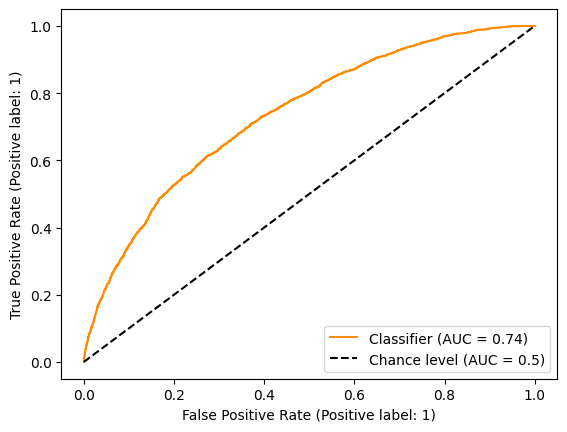

In [16]:
from sklearn.metrics import RocCurveDisplay

display = RocCurveDisplay.from_predictions(
    labels,
    preds,
    color="darkorange",
    plot_chance_level=True,
)